In [1]:
import pandas as pd
pd.__version__


'1.5.3'

In [2]:
import numpy as np
np.__version__

'1.22.4'

In [3]:
import numpy as np
np.__version__

'1.22.4'

In [4]:
import sklearn
sklearn.__version__

'1.2.2'

In [5]:
import lightgbm as lgb
lgb.__version__

'3.3.5'

In [6]:
import xgboost as xgb
xgb.__version__

'1.7.5'

In [7]:
import matplotlib
matplotlib.__version__

'3.7.1'

In [8]:
%pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import catboost
catboost.__version__

'1.2'

In [10]:
import pylab as plt
from scipy import stats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor

import time
import random

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
microclimate = pd.read_csv("drive/MyDrive/вкр/microclimate_cut_WITH_LIGHT_V2.csv")
soil = pd.read_csv("drive/MyDrive/вкр/soil_cut.csv")

### Анализ и предобработка данных

Пять признаков: концентрация CO2 (ppt), температура (°C), влажность воздуха (%), свет (blue, %), свет (white, %), свет (red, %)

In [13]:
microclimate.head()

,Время (час),Концентрация CO2 (ppt),Температура (°C),Влажность воздуха (%),"Свет (blue, %)","Свет (white, %)","Свет (red, %)"
0,0.002569,824.294648,18.721771,74.413899,0.0,0.0,0.0
1,0.010146,819.765307,18.709477,73.572382,0.0,0.0,0.0
2,0.017723,819.006237,18.726213,73.570151,0.0,0.0,0.0
3,0.025300,825.059458,18.706500,74.239905,0.0,0.0,0.0
4,0.032877,827.696900,18.806767,74.565687,0.0,0.0,0.0


In [14]:
def correction(x):
    if x < 15:
        x = 0
    elif x > 15 and x < 42.5:
        x = 30
    elif x > 42.5 and x < 62.5:
        x = 50
    elif x > 62.5 and x < 82.5:
        x = 70
    elif x > 82.5:
        x = 100
    return x

microclimate['Свет (blue, %)'] = microclimate['Свет (blue, %)'].apply(correction)
microclimate['Свет (white, %)'] = microclimate['Свет (white, %)'].apply(correction)
microclimate['Свет (red, %)'] = microclimate['Свет (red, %)'].apply(correction)

In [15]:
microclimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236742 entries, 0 to 236741
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Время (час)             236742 non-null  float64
 1   Концентрация CO2 (ppt)  236742 non-null  float64
 2   Температура (°C)        236742 non-null  float64
 3   Влажность воздуха (%)   236742 non-null  float64
 4   Свет (blue, %)          236742 non-null  int64  
 5   Свет (white, %)         236742 non-null  int64  
 6   Свет (red, %)           236742 non-null  int64  
dtypes: float64(4), int64(3)
memory usage: 12.6 MB


In [16]:
microclimate.describe()

,Время (час),Концентрация CO2 (ppt),Температура (°C),Влажность воздуха (%),"Свет (blue, %)","Свет (white, %)","Свет (red, %)"
count,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000
mean,896.876076,839.988570,21.623106,54.993618,11.636845,35.364278,13.671676
std,517.813442,68.519576,1.778478,10.101997,14.618143,34.984670,22.278614
min,0.002569,381.397885,18.168020,30.823036,0.000000,0.000000,0.000000
25%,448.439323,801.668477,20.246011,46.881879,0.000000,0.000000,0.000000
50%,896.876076,839.881859,21.294835,54.162818,0.000000,70.000000,0.000000
75%,1345.312830,880.085509,22.695449,63.184642,30.000000,70.000000,50.000000
max,1793.749583,1236.079686,27.984084,83.681035,30.000000,70.000000,50.000000


Четыре целевые переменные: процент влажности почвы для 1, 2, 4 и 8 литров торфа

In [17]:
soil.head()

,Время (час),1л,2л,4л,8л
0,0.002569,-4.989119,-3.672894,-5.911863,-6.743605
1,0.010146,-4.986277,-3.849423,-5.909429,-6.741132
2,0.017723,-4.983435,-3.689895,-5.906995,-6.738659
3,0.025300,-4.980593,-3.852541,-5.904560,-6.736185
4,0.032877,-4.977751,-3.681410,-5.718384,-6.733712


In [18]:
soil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236742 entries, 0 to 236741
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Время (час)  236742 non-null  float64
 1   1л           236742 non-null  float64
 2   2л           236742 non-null  float64
 3   4л           236742 non-null  float64
 4   8л           236742 non-null  float64
dtypes: float64(5)
memory usage: 9.0 MB


In [19]:
soil.describe()

,Время (час),1л,2л,4л,8л
count,236742.000000,236742.000000,236742.000000,236742.000000,236742.000000
mean,896.876076,66.400237,67.852809,69.052452,66.850561
std,517.813442,20.610623,20.668283,21.285000,20.679862
min,0.002569,-4.989119,-4.083342,-5.911863,-6.743605
25%,448.439323,62.859670,64.812774,62.588154,59.715718
50%,896.876076,71.924444,74.012449,73.983302,67.808963
75%,1345.312830,78.945478,80.688146,84.018449,84.080376
max,1793.749583,98.548742,97.678110,99.317980,101.677814


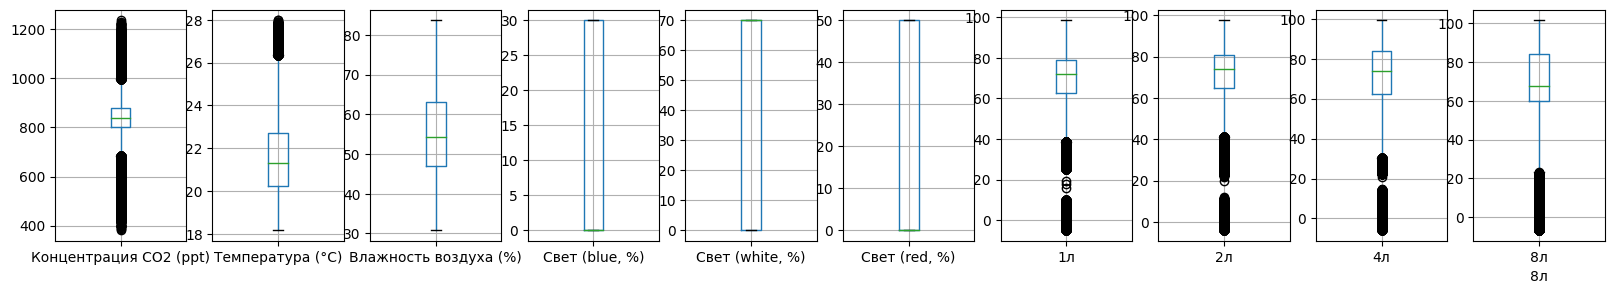

In [20]:
full_df = microclimate.drop(['Время (час)'], axis=1)
full_df['1л'] = soil['1л']
full_df['2л'] = soil['2л']
full_df['4л'] = soil['4л']
full_df['8л'] = soil['8л']

listvar = full_df.columns.tolist()
fig, axes = plt.subplots(nrows=1, ncols=len(listvar), figsize=(20, 3))
counter=0
for ax in axes:
    full_df.boxplot(column=listvar[counter], ax=axes[counter])
    plt.xlabel(listvar[counter])
    counter += 1
plt.show()

In [21]:
from scipy.stats import normaltest

for i in range(6):
    value, p = normaltest(full_df[listvar[i]].values)
    print(value, p)
    if p >= 0.05:
        print(f'It is likely that {listvar[i]} is normal')
    else:
        print(f'It is unlikely that {listvar[i]} is normal')
    print()

27634.199836323663 0.0
It is unlikely that Концентрация CO2 (ppt) is normal

20695.247386768857 0.0
It is unlikely that Температура (°C) is normal

26146.43271191299 0.0
It is unlikely that Влажность воздуха (%) is normal

940820.736982395 0.0
It is unlikely that Свет (blue, %) is normal

806948.323895923 0.0
It is unlikely that Свет (white, %) is normal

74157.13674895771 0.0
It is unlikely that Свет (red, %) is normal



Применение PowerTransformer (чтобы сделать распределения признаков гауссовским)

In [22]:
TargetVariable=['1л', '2л', '4л', '8л']
Predictors=['Концентрация CO2 (ppt)', 'Температура (°C)', 'Влажность воздуха (%)',
           'Свет (blue, %)', 'Свет (white, %)','Свет (red, %)']

X=full_df[Predictors].values
y=full_df[TargetVariable].values

pt = StandardScaler()
pt_ = pt.fit(X)
X = pt_.transform(X)

Разделение на обучающую и тестовую выборку

In [23]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 123)

Создание полиноминальных признаков второй степени

### Обучение моделей

In [24]:
import time

def time_since(since):
    now = time.time()
    s = now - since
    m = np.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

__LinearRegression__
- для 1 литра торфа

In [25]:
start = time.time()
trans = PolynomialFeatures(degree=3)
train_X_poly = trans.fit_transform(train_X)
val_X_poly = trans.fit_transform(val_X)
lin2 = LinearRegression()
lin2.fit(train_X_poly, train_y[:, 0])
predicted = lin2.predict(val_X_poly)
R2_poly_1 = r2_score(val_y[:, 0], predicted)
MAE_poly_1 = mean_absolute_error(val_y[:, 0], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 0], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')

time = 0m 2s
R-squared = 0.541
MAE = 10.143924608246564
MAPE = 0.8479788208906741


- для 2 литров торфа

In [26]:
start = time.time()
trans = PolynomialFeatures(degree=3)
train_X_poly = trans.fit_transform(train_X)
val_X_poly = trans.fit_transform(val_X)
lin2 = LinearRegression()
lin2.fit(train_X_poly, train_y[:, 1])
predicted = lin2.predict(val_X_poly)
R2_poly_2 = r2_score(val_y[:, 1], predicted)
MAE_poly_2 = mean_absolute_error(val_y[:, 1], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 1], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')

time = 0m 2s
R-squared = 0.469
MAE = 10.703715905244852
MAPE = 1.2756062496012577


- для 4 литров торфа

In [27]:
start = time.time()
trans = PolynomialFeatures(degree=3)
train_X_poly = trans.fit_transform(train_X)
val_X_poly = trans.fit_transform(val_X)
lin2 = LinearRegression()
lin2.fit(train_X_poly, train_y[:, 2])
predicted = lin2.predict(val_X_poly)
R2_poly_4 = r2_score(val_y[:, 2], predicted)
MAE_poly_4 = mean_absolute_error(val_y[:, 2], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 2], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')

time = 0m 4s
R-squared = 0.392
MAE = 11.744052041729413
MAPE = 1.68309008594743


- для 8 литров торфа

In [28]:
start = time.time()
trans = PolynomialFeatures(degree=3)
train_X_poly = trans.fit_transform(train_X)
val_X_poly = trans.fit_transform(val_X)
lin2 = LinearRegression()
lin2.fit(train_X_poly, train_y[:, 3])
predicted = lin2.predict(val_X_poly)
R2_poly_8 = r2_score(val_y[:, 3], predicted)
MAE_poly_8 = mean_absolute_error(val_y[:, 3], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 3], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')

time = 0m 5s
R-squared = 0.341
MAE = 11.228482668348217
MAPE = 4.48473898174725


__RandomForestRegressor__
- для 1 литра торфа

In [29]:
start = time.time()
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(train_X, train_y[:, 0])
predicted = regressor.predict(val_X)
R2_randforest_1 = r2_score(val_y[:, 0], predicted)
MAE_randforest_1 = mean_absolute_error(val_y[:, 0], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 0], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')

time = 2m 9s
R-squared = 0.820
MAE = 4.6740755286335
MAPE = 0.4810060440383838


- для 2 литров торфа

In [30]:
start = time.time()
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(train_X, train_y[:, 1])
predicted = regressor.predict(val_X)
R2_randforest_2 = r2_score(val_y[:, 1], predicted)
MAE_randforest_2 = mean_absolute_error(val_y[:, 1], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 1], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')

time = 1m 28s
R-squared = 0.789
MAE = 4.895848337099162
MAPE = 0.5523234572384819


- для 4 литров торфа

In [31]:
start = time.time()
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(train_X, train_y[:, 2])
predicted = regressor.predict(val_X)
R2_randforest_4 = r2_score(val_y[:, 2], predicted)
MAE_randforest_4 = mean_absolute_error(val_y[:, 2], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 2], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')

time = 1m 34s
R-squared = 0.769
MAE = 5.1957409195751305
MAPE = 0.8114490416971657


- для 8 литров торфа

In [32]:
start = time.time()
regressor = RandomForestRegressor(n_jobs=-1)
regressor.fit(train_X, train_y[:, 3])
predicted = regressor.predict(val_X)
R2_randforest_8 = r2_score(val_y[:, 3], predicted)
MAE_randforest_8 = mean_absolute_error(val_y[:, 3], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 3], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')

time = 1m 29s
R-squared = 0.750
MAE = 4.847574730878833
MAPE = 1.7857895642478425


__AdaBoostRegressor__
- для 1 литра торфа

In [33]:
start = time.time()
regressor = AdaBoostRegressor()
regressor.fit(train_X, train_y[:, 0])
predicted = regressor.predict(val_X)
R2_ada_1 = r2_score(val_y[:, 0], predicted)
MAE_ada_1 = mean_absolute_error(val_y[:, 0], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 0], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')

time = 0m 3s
R-squared = 0.459
MAE = 11.431885777307135
MAPE = 0.8304920355815553


- для 2 литров торфа

In [34]:
start = time.time()
regressor = AdaBoostRegressor()
regressor.fit(train_X, train_y[:, 1])
predicted = regressor.predict(val_X)
R2_ada_2 = r2_score(val_y[:, 1], predicted)
MAE_ada_2 = mean_absolute_error(val_y[:, 1], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 1], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')

time = 0m 2s
R-squared = 0.448
MAE = 11.279711978954387
MAPE = 1.1637993818690267


- для 4 литров торфа

In [35]:
start = time.time()
regressor = AdaBoostRegressor()
regressor.fit(train_X, train_y[:, 2])
predicted = regressor.predict(val_X)
R2_ada_4 = r2_score(val_y[:, 2], predicted)
MAE_ada_4 = mean_absolute_error(val_y[:, 2], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 2], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')

time = 0m 3s
R-squared = 0.345
MAE = 12.711385981361927
MAPE = 1.5463783560292415


- для 8 литров торфа

In [36]:
start = time.time()
regressor = AdaBoostRegressor()
regressor.fit(train_X, train_y[:, 3])
predicted = regressor.predict(val_X)
R2_ada_8 = r2_score(val_y[:, 3], predicted)
MAE_ada_8 = mean_absolute_error(val_y[:, 3], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 3], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')

time = 0m 3s
R-squared = 0.290
MAE = 12.7157222055355
MAPE = 4.000441392909636


__CatBoostRegressor__
- для 1 литра торфа

In [37]:
start = time.time()
m = CatBoostRegressor()
m.fit(train_X, train_y[:, 0])
predicted = m.predict(val_X)
R2_cat_1 = r2_score(val_y[:, 0], predicted)
MAE_cat_1 = mean_absolute_error(val_y[:, 0], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 0], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')

Learning rate set to 0.093757
0:	learn: 19.6246934	total: 79.8ms	remaining: 1m 19s
1:	learn: 18.7743030	total: 102ms	remaining: 50.8s
2:	learn: 18.0239222	total: 124ms	remaining: 41.2s
3:	learn: 17.3851524	total: 149ms	remaining: 37.1s
4:	learn: 16.8250858	total: 171ms	remaining: 34s
5:	learn: 16.3328639	total: 192ms	remaining: 31.9s
6:	learn: 15.9299712	total: 214ms	remaining: 30.3s
7:	learn: 15.5407247	total: 234ms	remaining: 29.1s
8:	learn: 15.2086365	total: 255ms	remaining: 28s
9:	learn: 14.9345586	total: 276ms	remaining: 27.3s
10:	learn: 14.6835904	total: 297ms	remaining: 26.7s
11:	learn: 14.4644055	total: 318ms	remaining: 26.2s
12:	learn: 14.2724256	total: 338ms	remaining: 25.7s
13:	learn: 14.0918012	total: 364ms	remaining: 25.6s
14:	learn: 13.9333573	total: 386ms	remaining: 25.3s
15:	learn: 13.8096511	total: 406ms	remaining: 25s
16:	learn: 13.6667245	total: 433ms	remaining: 25s
17:	learn: 13.5713473	total: 453ms	remaining: 24.7s
18:	learn: 13.4489685	total: 474ms	remaining: 24.5

- для 2 литров торфа

In [38]:
start = time.time()
m = CatBoostRegressor()
m.fit(train_X, train_y[:, 1])
predicted = m.predict(val_X)
R2_cat_2 = r2_score(val_y[:, 1], predicted)
MAE_cat_2 = mean_absolute_error(val_y[:, 1], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 1], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')

Learning rate set to 0.093757
0:	learn: 19.7807813	total: 22.3ms	remaining: 22.3s
1:	learn: 19.0602504	total: 43ms	remaining: 21.4s
2:	learn: 18.4111788	total: 69.6ms	remaining: 23.1s
3:	learn: 17.8173262	total: 90ms	remaining: 22.4s
4:	learn: 17.3471963	total: 111ms	remaining: 22s
5:	learn: 16.9165818	total: 132ms	remaining: 21.9s
6:	learn: 16.5345672	total: 157ms	remaining: 22.2s
7:	learn: 16.2207779	total: 177ms	remaining: 22s
8:	learn: 15.9365633	total: 198ms	remaining: 21.8s
9:	learn: 15.7020104	total: 218ms	remaining: 21.6s
10:	learn: 15.5068550	total: 238ms	remaining: 21.4s
11:	learn: 15.3202982	total: 258ms	remaining: 21.2s
12:	learn: 15.1521129	total: 278ms	remaining: 21.1s
13:	learn: 15.0041290	total: 298ms	remaining: 21s
14:	learn: 14.8531154	total: 320ms	remaining: 21s
15:	learn: 14.7275557	total: 363ms	remaining: 22.3s
16:	learn: 14.6106959	total: 386ms	remaining: 22.3s
17:	learn: 14.5214161	total: 408ms	remaining: 22.2s
18:	learn: 14.4303588	total: 428ms	remaining: 22.1s


- для 4 литров торфа

In [39]:
start = time.time()
m = CatBoostRegressor()
m.fit(train_X, train_y[:, 2])
predicted = m.predict(val_X)
R2_cat_4 = r2_score(val_y[:, 2], predicted)
MAE_cat_4 = mean_absolute_error(val_y[:, 2], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 2], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')

Learning rate set to 0.093757
0:	learn: 20.4703946	total: 58.1ms	remaining: 58s
1:	learn: 19.8098283	total: 120ms	remaining: 59.8s
2:	learn: 19.2301437	total: 177ms	remaining: 59s
3:	learn: 18.7328998	total: 229ms	remaining: 57s
4:	learn: 18.2962290	total: 280ms	remaining: 55.7s
5:	learn: 17.9414043	total: 330ms	remaining: 54.6s
6:	learn: 17.6376041	total: 383ms	remaining: 54.4s
7:	learn: 17.3240540	total: 438ms	remaining: 54.3s
8:	learn: 17.0557082	total: 497ms	remaining: 54.7s
9:	learn: 16.8612587	total: 547ms	remaining: 54.1s
10:	learn: 16.6851998	total: 603ms	remaining: 54.2s
11:	learn: 16.4853674	total: 654ms	remaining: 53.9s
12:	learn: 16.3258016	total: 702ms	remaining: 53.3s
13:	learn: 16.1979448	total: 746ms	remaining: 52.5s
14:	learn: 16.0771717	total: 797ms	remaining: 52.4s
15:	learn: 15.9632815	total: 850ms	remaining: 52.3s
16:	learn: 15.8501819	total: 898ms	remaining: 51.9s
17:	learn: 15.7588014	total: 944ms	remaining: 51.5s
18:	learn: 15.6845510	total: 995ms	remaining: 51.

- для 8 литров торфа

In [40]:
start = time.time()
m = CatBoostRegressor()
m.fit(train_X, train_y[:, 3])
predicted = m.predict(val_X)
R2_cat_8 = r2_score(val_y[:, 3], predicted)
MAE_cat_8 = mean_absolute_error(val_y[:, 3], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 3], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')

Learning rate set to 0.093757
0:	learn: 19.9709348	total: 33.9ms	remaining: 33.8s
1:	learn: 19.3693307	total: 70.5ms	remaining: 35.2s
2:	learn: 18.8540787	total: 122ms	remaining: 40.4s
3:	learn: 18.4063388	total: 171ms	remaining: 42.6s
4:	learn: 18.0279641	total: 221ms	remaining: 44.1s
5:	learn: 17.7068951	total: 271ms	remaining: 44.8s
6:	learn: 17.4183974	total: 323ms	remaining: 45.8s
7:	learn: 17.1857942	total: 372ms	remaining: 46.1s
8:	learn: 16.9633995	total: 423ms	remaining: 46.6s
9:	learn: 16.7780490	total: 470ms	remaining: 46.5s
10:	learn: 16.6142458	total: 521ms	remaining: 46.9s
11:	learn: 16.4826401	total: 573ms	remaining: 47.2s
12:	learn: 16.3646735	total: 624ms	remaining: 47.4s
13:	learn: 16.2629168	total: 676ms	remaining: 47.6s
14:	learn: 16.1802290	total: 724ms	remaining: 47.5s
15:	learn: 16.0730228	total: 758ms	remaining: 46.6s
16:	learn: 15.9631296	total: 797ms	remaining: 46.1s
17:	learn: 15.8749084	total: 840ms	remaining: 45.8s
18:	learn: 15.7875632	total: 892ms	remaini

__LGBMRegressor__
- для 1 литра торфа

In [41]:
start = time.time()
m = lgb.LGBMRegressor(objective='regression')
m.fit(train_X, train_y[:, 0])
predicted = m.predict(val_X)
R2_lgbm_1 = r2_score(val_y[:, 0], predicted)
MAE_lgbm_1 = mean_absolute_error(val_y[:, 0], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 0], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')

time = 0m 1s
R-squared = 0.726
MAE = 7.415417545522056
MAPE = 0.6321236442680703


- для 2 литров торфа

In [42]:
start = time.time()
m = lgb.LGBMRegressor(objective='regression')
m.fit(train_X, train_y[:, 1])
predicted = m.predict(val_X)
R2_lgbm_2 = r2_score(val_y[:, 1], predicted)
MAE_lgbm_2 = mean_absolute_error(val_y[:, 1], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 1], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')

time = 0m 1s
R-squared = 0.684
MAE = 7.694581453297843
MAPE = 0.8400682306874092


- для 4 литров торфа

In [43]:
start = time.time()
m = lgb.LGBMRegressor()
m.fit(train_X, train_y[:, 2])
predicted = m.predict(val_X)
R2_lgbm_4 = r2_score(val_y[:, 2], predicted)
MAE_lgbm_4 = mean_absolute_error(val_y[:, 2], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 2], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')

time = 0m 4s
R-squared = 0.643
MAE = 8.36901017991291
MAPE = 1.2769612051374981


- для 8 литров торфа

In [44]:
start = time.time()
m = lgb.LGBMRegressor()
m.fit(train_X, train_y[:, 3])
predicted = m.predict(val_X)
R2_lgbm_8 = r2_score(val_y[:, 3], predicted)
MAE_lgbm_8 = mean_absolute_error(val_y[:, 3], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 3], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')

time = 0m 0s
R-squared = 0.617
MAE = 7.775283953880718
MAPE = 2.740811358815486


__XGB__
- для 1 литра торфа

In [45]:
start = time.time()
dtrain_reg = xgb.DMatrix(train_X, train_y[:, 0])
dtest_reg = xgb.DMatrix(val_X, val_X[:, 0])
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
m = xgb.train(params=params, dtrain=dtrain_reg)
predicted = m.predict(dtest_reg)
R2_xgb_1 = r2_score(val_y[:, 0], predicted)
MAE_xgb_1 = mean_absolute_error(val_y[:, 0], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 0], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 0], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 0], predicted)}')

time = 0m 0s
R-squared = 0.676
MAE = 8.422461254733356
MAPE = 0.6818886547061431


- для 2 литров торфа

In [46]:
start = time.time()
dtrain_reg = xgb.DMatrix(train_X, train_y[:, 1])
dtest_reg = xgb.DMatrix(val_X, val_X[:, 1])
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
m = xgb.train(params=params, dtrain=dtrain_reg)
predicted = m.predict(dtest_reg)
R2_xgb_2 = r2_score(val_y[:, 1], predicted)
MAE_xgb_2 = mean_absolute_error(val_y[:, 1], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 1], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 1], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 1], predicted)}')

time = 0m 0s
R-squared = 0.630
MAE = 8.7378710323483
MAPE = 0.9238573819124306


- для 4 литров торфа

In [47]:
start = time.time()
dtrain_reg = xgb.DMatrix(train_X, train_y[:, 2])
dtest_reg = xgb.DMatrix(val_X, val_X[:, 2])
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
m = xgb.train(params=params, dtrain=dtrain_reg)
predicted = m.predict(dtest_reg)
R2_xgb_4 = r2_score(val_y[:, 2], predicted)
MAE_xgb_4 = mean_absolute_error(val_y[:, 2], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 2], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 2], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 2], predicted)}')

time = 0m 0s
R-squared = 0.582
MAE = 9.538305907715646
MAPE = 1.3710903401515337


- для 8 литров торфа

In [48]:
start = time.time()
dtrain_reg = xgb.DMatrix(train_X, train_y[:, 3])
dtest_reg = xgb.DMatrix(val_X, val_X[:, 3])
params = {"objective": "reg:squarederror", "tree_method": "gpu_hist"}
m = xgb.train(params=params, dtrain=dtrain_reg)
predicted = m.predict(dtest_reg)
R2_xgb_8 = r2_score(val_y[:, 3], predicted)
MAE_xgb_8 = mean_absolute_error(val_y[:, 3], predicted)
print(f'time = {time_since(start)}')
print(f'R-squared = {r2_score(val_y[:, 3], predicted):.3f}')
print(f'MAE = {mean_absolute_error(val_y[:, 3], predicted)}')
print(f'MAPE = {mean_absolute_percentage_error(val_y[:, 3], predicted)}')

time = 0m 0s
R-squared = 0.551
MAE = 8.923318751427365
MAPE = 3.465220498187942


Barplots

In [49]:
Polynom = {"R-squared 1 литр торфа": R2_poly_1,
           "R-squared 2 литра торфа": R2_poly_2,
           "R-squared 4 литра торфа": R2_poly_4,
           "R-squared 8 литров торфа":R2_poly_8,
           "MAE 1 литр торфа": MAE_poly_1,
           "MAE 2 литра торфа": MAE_poly_2,
           "MAE 4 литра торфа": MAE_poly_4,
           "MAE 8 литров торфа": MAE_poly_8}
RandomForest = {"R-squared 1 литр торфа": R2_randforest_1,
                "R-squared 2 литра торфа": R2_randforest_2,
                "R-squared 4 литра торфа": R2_randforest_4,
                "R-squared 8 литров торфа": R2_randforest_8,
                "MAE 1 литр торфа": MAE_randforest_1,
                "MAE 2 литра торфа": MAE_randforest_2,
                "MAE 4 литра торфа": MAE_randforest_4,
                "MAE 8 литров торфа": MAE_randforest_8}
AdaBoost = {"R-squared 1 литр торфа": R2_ada_1,
            "R-squared 2 литра торфа": R2_ada_2,
            "R-squared 4 литра торфа": R2_ada_4,
            "R-squared 8 литров торфа": R2_ada_8,
            "MAE 1 литр торфа": MAE_ada_1,
            "MAE 2 литра торфа": MAE_ada_2,
            "MAE 4 литра торфа": MAE_ada_4,
            "MAE 8 литров торфа": MAE_ada_8}
CatBoost = {"R-squared 1 литр торфа": R2_cat_1,
            "R-squared 2 литра торфа": R2_cat_2,
            "R-squared 4 литра торфа": R2_cat_4,
            "R-squared 8 литров торфа": R2_cat_8,
            "MAE 1 литр торфа": MAE_cat_1,
            "MAE 2 литра торфа": MAE_cat_2,
            "MAE 4 литра торфа": MAE_cat_4,
            "MAE 8 литров торфа": MAE_cat_8}
LGBM = {"R-squared 1 литр торфа": R2_lgbm_1,
        "R-squared 2 литра торфа": R2_lgbm_2,
        "R-squared 4 литра торфа": R2_lgbm_4,
        "R-squared 8 литров торфа": R2_lgbm_8,
        "MAE 1 литр торфа": MAE_lgbm_1,
        "MAE 2 литра торфа": MAE_lgbm_2,
        "MAE 4 литра торфа": MAE_lgbm_4,
        "MAE 8 литров торфа": MAE_lgbm_8}
XGBoost = {"R-squared 1 литр торфа": R2_xgb_1,
           "R-squared 2 литра торфа": R2_xgb_2,
           "R-squared 4 литра торфа": R2_xgb_4,
           "R-squared 8 литров торфа": R2_xgb_8,
           "MAE 1 литр торфа": MAE_xgb_1,
           "MAE 2 литра торфа": MAE_xgb_2,
           "MAE 4 литра торфа": MAE_xgb_4,
           "MAE 8 литров торфа": MAE_xgb_8}


pdd = pd.DataFrame([Polynom, RandomForest, AdaBoost, CatBoost, LGBM, XGBoost],
                   index=["Polynom", "RandomForest", "AdaBoost", "CatBoost", "LGBM", "XGBoost"])
pdd_r2 = pdd[['R-squared 1 литр торфа', 'R-squared 2 литра торфа', 'R-squared 4 литра торфа', 'R-squared 8 литров торфа']].T
pdd_mae = pdd[['MAE 1 литр торфа', 'MAE 2 литра торфа', 'MAE 4 литра торфа', 'MAE 8 литров торфа']].T
colors = {"Polynom": "#A9A9A9", "RandomForest": "#B00000", "AdaBoost": "#808080", "CatBoost": "#696969", "LGBM": "#778899", "XGBoost": "#2F4F4F"}

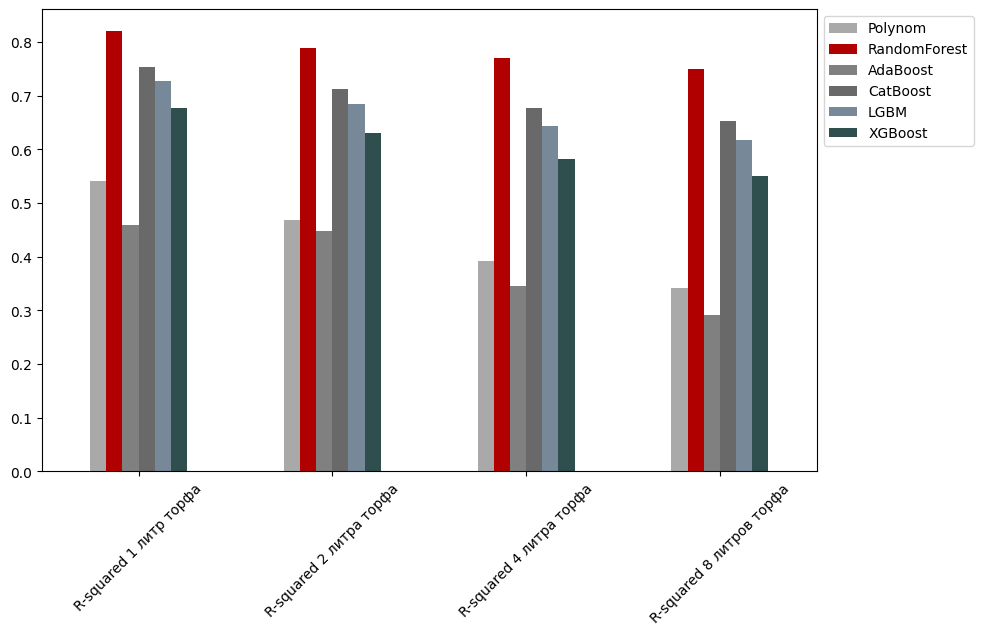

In [50]:
pdd_r2.plot.bar(figsize=(10, 6), color=colors)
plt.xticks(rotation = 45)
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()

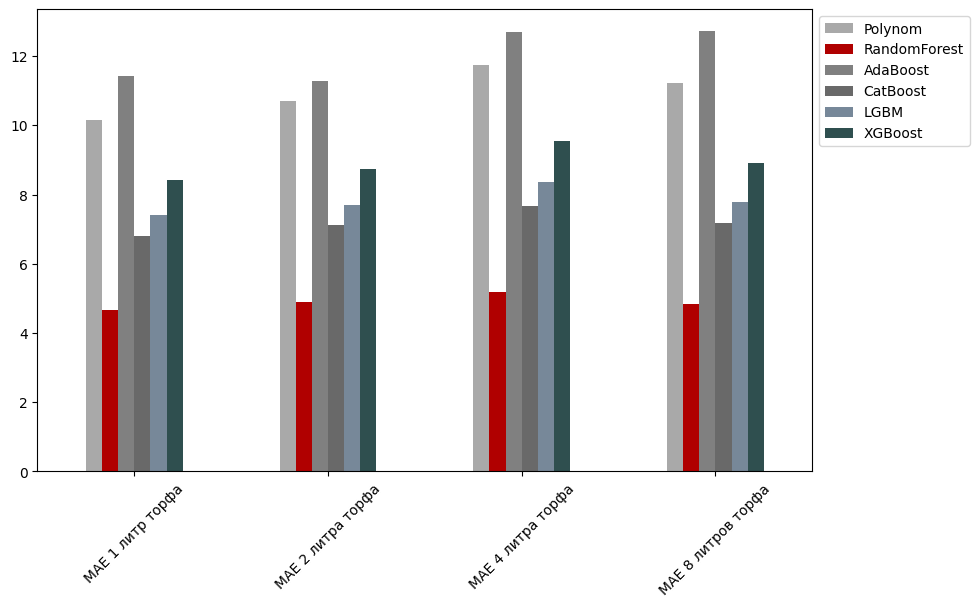

In [51]:
pdd_mae.plot.bar(figsize=(10, 6), color=colors)
plt.xticks(rotation = 45)
plt.legend(loc = 2, bbox_to_anchor = (1,1))
plt.show()